In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/adult-census-income/adult.csv


In [2]:
#Import necessary libraries
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn import set_config
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures,RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LassoCV,RidgeCV,ElasticNetCV
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder

sns.set_context("paper", font_scale = 1, rc={"grid.linewidth": 3})
pd.set_option('display.max_rows', 100, 'display.max_columns', 400)

from scipy.stats import skew,boxcox_normmax
from scipy.special import boxcox1p
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRFRegressor,XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor,ExtraTreesRegressor


# Preliminary Data Examination

In [3]:
# Set a seed value
seed_value= 12321 

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
# import tensorflow as tf
# tf.set_random_seed(seed_value)

# 5. For layers that introduce randomness like dropout, make sure to set seed values 
# model.add(Dropout(0.25, seed=seed_value))

# 6. Configure a new global `tensorflow` session
# from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

In [4]:
# Reading in the data
data = pd.read_csv("../input/adult-census-income/adult.csv")

# Printing shape of data
print(data.shape)

(32561, 15)


In [5]:
## Some preliminary examination
# look at data
display(data.head())

# look a shape of data
display(data.shape)

# look at data types. Ideally look at all rows. Only look at first five here for minimal output.
display(data.iloc[:5,:5].dtypes)

# see if any columns have nulls. Ideally look at all rows. Only look at first five here for minimal output.
display(data.iloc[:5,:5].isnull().any())

# display descriptive statistics
display(data.describe(percentiles=[0.25,0.5,0.75,0.85,0.95,0.99]))

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


(32561, 15)

age               int64
workclass        object
fnlwgt            int64
education        object
education.num     int64
dtype: object

age              False
workclass        False
fnlwgt           False
education        False
education.num    False
dtype: bool

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
85%,54.000000,2.894050e+05,13.000000,0.000000,0.000000,50.000000
95%,63.000000,3.796820e+05,14.000000,5013.000000,0.000000,60.000000
99%,74.000000,5.100720e+05,16.000000,15024.000000,1980.000000,80.000000


In [6]:
# Remove duplicates from data 
data.drop_duplicates(inplace=True)

# Check for appropriate data types 
for col in data.columns:
    print(col + "-" * len(str(col)) + str(data[col].dtype))

age---int64
workclass---------object
fnlwgt------int64
education---------object
education.num-------------int64
marital.status--------------object
occupation----------object
relationship------------object
race----object
sex---object
capital.gain------------int64
capital.loss------------int64
hours.per.week--------------int64
native.country--------------object
income------object


In [7]:
# A preliminary examination of data 
data.head(10)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
5,34,Private,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K
6,38,Private,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K
7,74,State-gov,88638,Doctorate,16,Never-married,Prof-specialty,Other-relative,White,Female,0,3683,20,United-States,>50K
8,68,Federal-gov,422013,HS-grad,9,Divorced,Prof-specialty,Not-in-family,White,Female,0,3683,40,United-States,<=50K
9,41,Private,70037,Some-college,10,Never-married,Craft-repair,Unmarried,White,Male,0,3004,60,?,>50K


In [8]:
# Check for null values
print(data.isnull().sum())
print("-"*100)

# Summary statistics 
print(data.describe())
print("-"*100)

# Count unique values in each column 
for col in data.columns:
    print(col + "-" * len(str(col)) + str(data[col].nunique()))
print("-"*100)
    
# Check the target balance 
print(data['income'].value_counts())

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64
----------------------------------------------------------------------------------------------------
                age        fnlwgt  education.num  capital.gain  capital.loss  \
count  32537.000000  3.253700e+04   32537.000000  32537.000000  32537.000000   
mean      38.585549  1.897808e+05      10.081815   1078.443741     87.368227   
std       13.637984  1.055565e+05       2.571633   7387.957424    403.101833   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.369

In [9]:
# Separate numerical columns and categorical columns 
categorical_cols = [col for col in data.columns if data[col].dtype == 'object']
numerical_cols = [col for col in data.columns if col not in categorical_cols]

*Observations*:
1. There seem to be some unidentified question marks in the data. It doesn't represent a null value. Hence, we need to take care of that. 
2. Clean up the income column. Encode the two uncleaned labels. 
3. From early inspections, it seems that the data is normally distributed except for capital.gain and capital.loss columns. 
4. There are no null values in the dataset. 
5. The dataset is slighlty imabalanced. Hence we need to work that out. 

In [10]:
# Separate features and labels
X = data.iloc[:, :-1]
y = data['income']

# Separate the dataset into training, validation AND test sets. 70%, 15% AND 15% for training, validation and testing \
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=y, random_state=seed_value)

In [11]:
num_data_train = X_train[numerical_cols]
cat_data_train = X_train[['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']]
num_data_test = X_test[numerical_cols]
cat_data_test = X_test[['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']]

# Initializing Base Column Transformer Class

In [12]:
# class DummyTransformer(BaseEstimator, TransformerMixin):
#     """
#     Transformer to select a single column from the data frame to perform additional transformations
    
#     """
#     def __init__(self, key):
#         self.key = key

#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         return X[self.key]

## Numerical Pipeline

In [13]:
def plot_kdeplot(dataframe):
    plt.figure(figsize=(30, 15))
    count = 1
    for col in dataframe.columns:
        plt.subplot(3, 2, count)
        # sns.histplot(data=data, x=str(col), binwidth=(data[col].max()-data[col].min())/100)
        sns.kdeplot(data=data, x=str(col))
        plt.xlabel(col, size=15)
        plt.ylabel("Count", size=15)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        count += 1
    
def plot_boxplot(dataframe):
    plt.figure(figsize=(30, 15))
    count = 1
    for col in dataframe.columns:
        plt.subplot(3, 2, count)
        sns.boxplot(data=data, x=str(col))
        plt.xlabel(col, size=15)
        plt.ylabel("Count", size=15)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        count += 1

In [15]:
# A basic code block for outlier removal FOR NON-GAUSSIAN Distributions. Will work as the agenda is to understand Pipelines
# None of the distributions are normally distributed. HENCE, we use the following function for outlier removal 
# Use and apply other procedures as well. Add to the list
# It all depends on the end goal as to what classifier I would apply. If the data has 
def outlier_removal(dataframe):
    for col in dataframe.columns:
        Q1 = dataframe[col].quantile(0.25)
        Q3 = dataframe[col].quantile(0.75)
        IQR = Q3 - Q1
        whisker_width = 1.5
        lower_whisker = Q1 - (whisker_width*IQR)
        upper_whisker = Q3 + (whisker_width*IQR)
        dataframe[str(col)] = np.where(dataframe[col]>upper_whisker, upper_whisker, dataframe[col])
        dataframe[str(col)] = np.where(dataframe[col]<lower_whisker, lower_whisker, dataframe[col])
    return dataframe
    
# Study how can I use it tomorrow
# class SpecificOutlierRemoval(DummyTransformer):
#     def transform(self, X, key):
#         X[self.key] = np.where(X[self.key] > 0.4*1e6, 0.4*1e6, X[self.key])
#         return X
    
# Create a function transformer
remove_outliers = FunctionTransformer(outlier_removal)

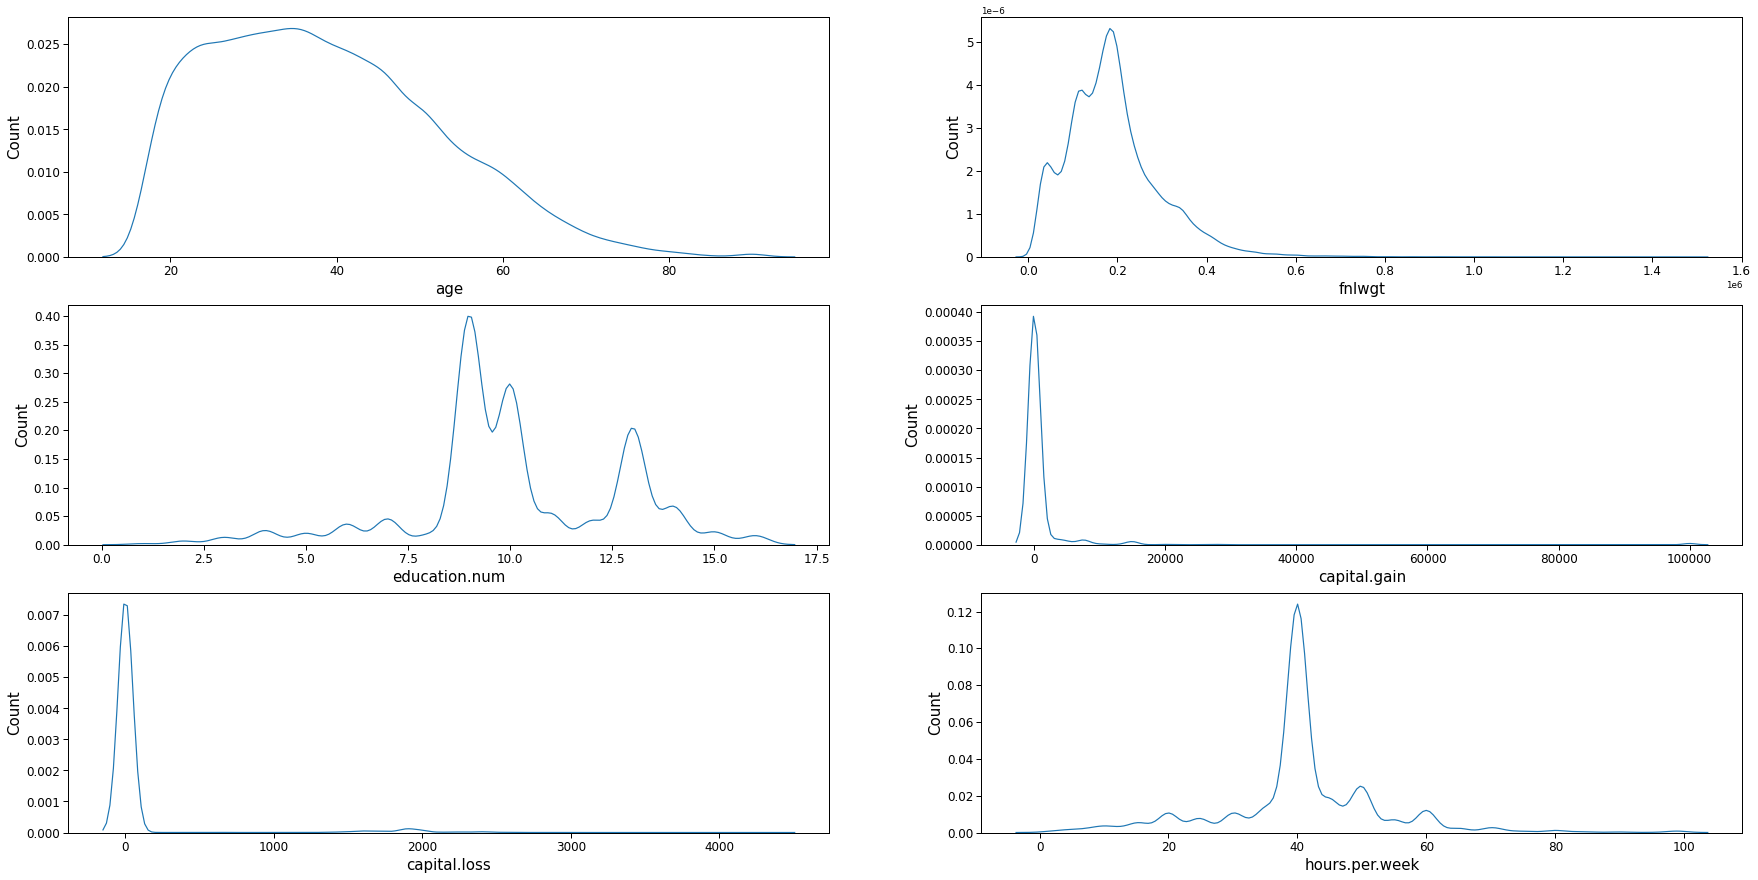

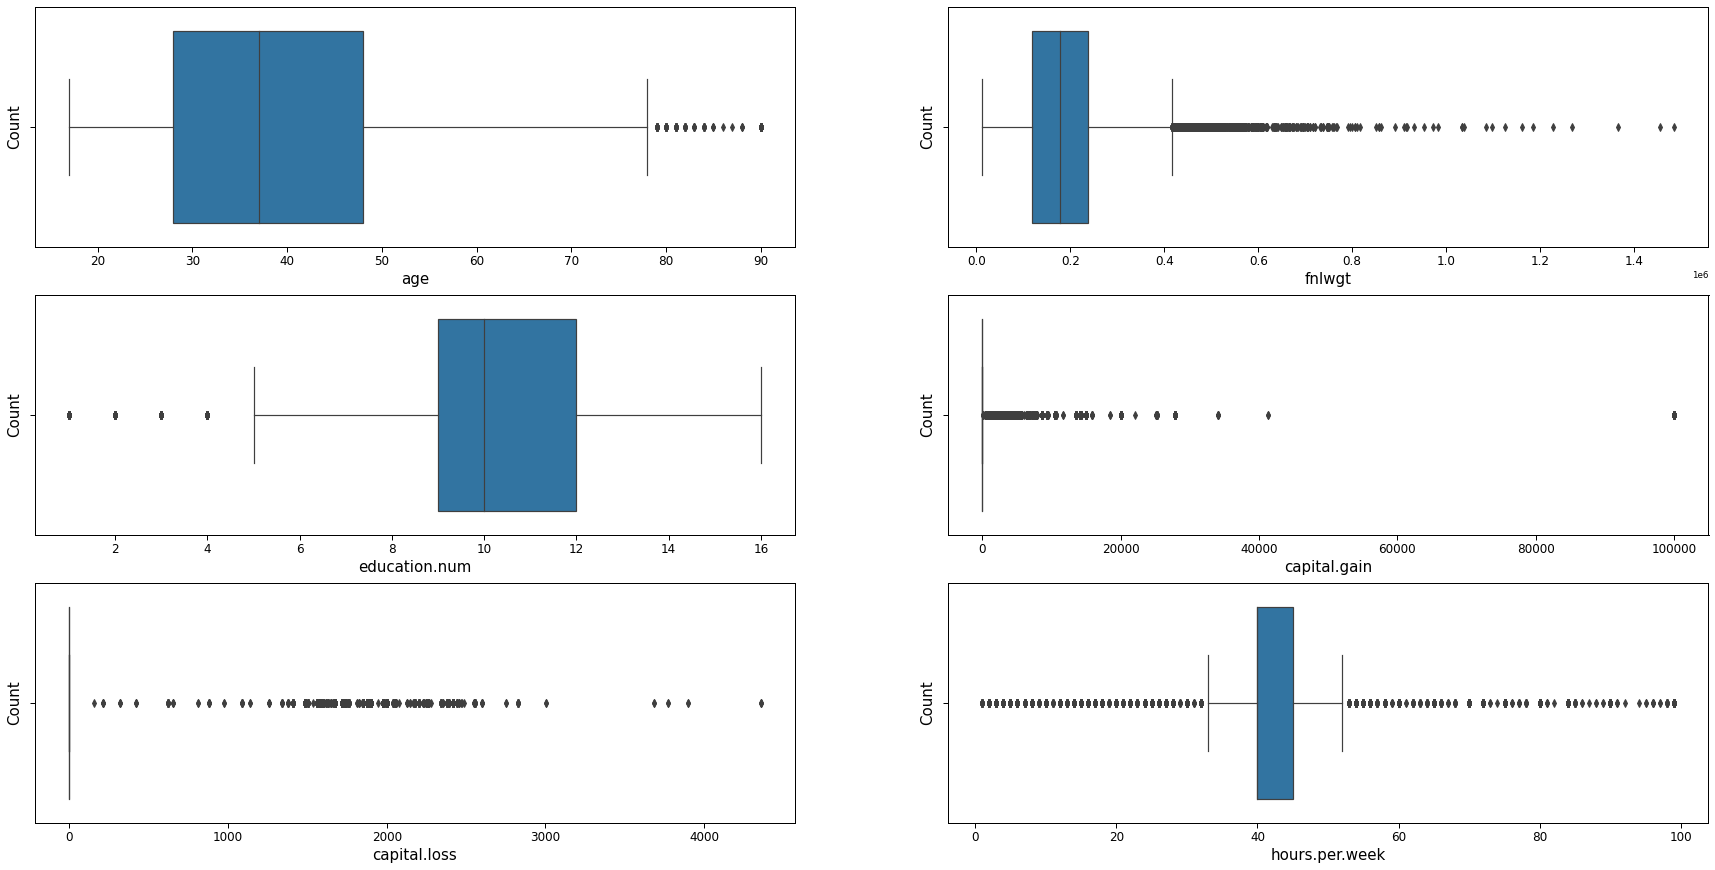

In [16]:
# Visualize KDE plot AND box-plots
plot_kdeplot(num_data_train)
plot_boxplot(num_data_train)

In [17]:
# Perform Standardization or Min-Max Scaler
# Add more to the list. Create a feature union 
num_transformed_1 = ColumnTransformer([
                                        ("outlier_removal", remove_outliers, slice(0, 6))
                                     ], 
remainder='passthrough')


num_transformed_2 = ColumnTransformer([
                                         ("Feature Scaling", StandardScaler(), slice(0, 6))
                                     ])
                                    
num_pipeline = Pipeline([
                           ("Outlier Removal", num_transformed_1),
                           ("Feature Scaling", num_transformed_2)
])

num_data_train_v1 = num_pipeline.fit_transform(num_data_train)
num_data_test_v1 = num_pipeline.transform(num_data_test)

train_num_data_v1 = pd.DataFrame(num_data_train_v1)
test_num_data_v1 = pd.DataFrame(num_data_test_v1)

#Changing the column names in order to facilitate changes in pipeline later
train_num_data_v1.columns = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
test_num_data_v1.columns = train_num_data_v1.columns

In [18]:
# Visualize the pipe
set_config(display="diagram")
num_pipeline

Pipeline(steps=[('Outlier Removal',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('outlier_removal',
                                                  FunctionTransformer(func=<function outlier_removal at 0x7f5b2aaa80e0>),
                                                  slice(0, 6, None))])),
                ('Feature Scaling',
                 ColumnTransformer(transformers=[('Feature Scaling',
                                                  StandardScaler(),
                                                  slice(0, 6, None))]))])

## Categorical Pipeline

In [19]:
def clean_data(dataframe):
    for col in dataframe.columns:
        dataframe[col] = np.where(dataframe[col] == "?", "Missing", dataframe[col])
    return dataframe


def label_encode(value):
    dataframe = pd.DataFrame(value)
    for col_index in range(len(dataframe.columns)):
        data_dict = {val:i for (i, val) in enumerate(dataframe.iloc[:, col_index].unique())}
        dataframe.iloc[:, col_index] = dataframe.iloc[:, col_index].map(data_dict)
    return dataframe

# Create function transformers
remove_markers = FunctionTransformer(clean_data)
encode_values = FunctionTransformer(label_encode)

In [20]:
# Apply to columns
cat_transformed_1 = ColumnTransformer([
                                        ("data_clean", remove_markers, slice(0, 8))
])

cat_transformed_2 = ColumnTransformer([
                                        ("cat_encode", encode_values, slice(0, 8))
])

# Create a pipeline 
cat_pipeline = Pipeline([
                            ("Data Cleaning", cat_transformed_1), 
                            ("One-Hot Encoding", cat_transformed_2)
])

# Fit and transform on train data
train_cat_data_v1 = pd.DataFrame(cat_pipeline.fit_transform(cat_data_train))
test_cat_data_v1 = pd.DataFrame(cat_pipeline.transform(cat_data_test))


# Changing the column names in order to facilitate changes in pipeline later
train_cat_data_v1.columns = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
test_cat_data_v1.columns = train_cat_data_v1.columns

In [21]:
# Visualize the pipe
set_config(display="diagram")
cat_pipeline

Pipeline(steps=[('Data Cleaning',
                 ColumnTransformer(transformers=[('data_clean',
                                                  FunctionTransformer(func=<function clean_data at 0x7f5b1fc30170>),
                                                  slice(0, 8, None))])),
                ('One-Hot Encoding',
                 ColumnTransformer(transformers=[('cat_encode',
                                                  FunctionTransformer(func=<function label_encode at 0x7f5b1fc30320>),
                                                  slice(0, 8, None))]))])

# Target Variable Transformation AND Feature-Space Concatenation

In [22]:
# Target-Variable Transformation 
train_target = label_encode(y_train)
test_target = label_encode(y_test)

# Feature-Space Concatenation for training and test data
X_train_features = pd.concat([train_num_data_v1, train_cat_data_v1], axis=1)
X_test_features = pd.concat([test_num_data_v1, test_cat_data_v1], axis=1)

# Modelling Data

In [23]:
# Split the dataset 
X_train, X_valid, y_train, y_valid = train_test_split(X_train_features, train_target, test_size=0.15, shuffle=y_train, random_state=seed_value)


# Initialize classifiers and feed them into pipelines 
lr = LogisticRegression(random_state=seed_value)
lr_pipe = Pipeline([
                     ("Logistic Regression", lr)
])

svc = LinearSVC(random_state=seed_value)
svc_pipe = Pipeline([
                     ("Linear Support Vector Classifier", svc)
])

dt = DecisionTreeClassifier(random_state=seed_value)
dt_pipe = Pipeline([
                     ("Decision Tree Classifier", dt)
])

rf = RandomForestClassifier(random_state=seed_value)
rf_pipe = Pipeline([
                     ("Random Forest Classfier", rf)
])

# Coalesce pipes
classifier_pipes = [lr_pipe, svc_pipe, dt_pipe, rf_pipe]
for clf_pipe in classifier_pipes:
    score = cross_val_score(clf_pipe, X_train_features, train_target, cv=5, scoring="f1")
    print(f"The cross-validation score from {clf_pipe}'s nozzle is in range {score}")
    print()

The cross-validation score from Pipeline(steps=[('Logistic Regression',
                 LogisticRegression(random_state=12321))])'s nozzle is in range [0.53472537 0.51563208 0.51519274 0.52867384 0.55063291]

The cross-validation score from Pipeline(steps=[('Linear Support Vector Classifier',
                 LinearSVC(random_state=12321))])'s nozzle is in range [0.52153558 0.5064695  0.50232558 0.51011029 0.53320861]

The cross-validation score from Pipeline(steps=[('Decision Tree Classifier',
                 DecisionTreeClassifier(random_state=12321))])'s nozzle is in range [0.54713494 0.54270987 0.53742515 0.5480663  0.55308092]

The cross-validation score from Pipeline(steps=[('Random Forest Classfier',
                 RandomForestClassifier(random_state=12321))])'s nozzle is in range [0.61557277 0.60218535 0.59375    0.61786002 0.60956341]



# Further observations and changes to the pipeline in future work 